In [101]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from dotenv import load_dotenv 
import numpy as np
import json
from transformers import CLIPProcessor, CLIPModel
from transformers import AutoTokenizer

In [102]:
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")
RECORD_IDS_TESTING_SET = PARENT + os.getenv("RECORD_IDS_TESTING_SET")
RECORD_IDS_VALIDATION_SET = PARENT + os.getenv("RECORD_IDS_VALIDATION_SET")
FILE_FABRITIUS_ICONOGRAPHIES_JSON = PARENT + os.getenv("FILE_FABRITIUS_ICONOGRAPHIES_JSON")

OUTPUT_MOONDREAM_CAPTIONS = PARENT + os.getenv("OUTPUT_MOONDREAM_CAPTIONS")
FILE_SUBJECTMATTERS_PARSED = PARENT + os.getenv("FILE_SUBJECTMATTERS_PARSED")

In [103]:
LANG = "FR"
TOKEN_LIMIT = 75 # Because of [SOS] and [EOS] tokens

In [104]:
base_name = "openai/clip-vit-large-patch14"
processor = CLIPProcessor.from_pretrained(base_name)
model = CLIPModel.from_pretrained(base_name)
tokenizer = AutoTokenizer.from_pretrained(base_name)

In [105]:
training_dataset = pd.DataFrame(columns=[
    "record_id",
    "row_type",
    "caption",
    "number_of_tokens"
])
training_dataset

,record_id,row_type,caption,number_of_tokens


In [106]:
moondream_captions = pd.read_csv(OUTPUT_MOONDREAM_CAPTIONS)
moondream_captions.head(5)

,recordID,task,EN,FR,NL
0,64,caption,A religious scene features a central figure o...,Une scène religieuse présente une figure centr...,Een religieuze scène toont een centrale figuur...
1,64,What objects do you see ?,"In the image, there are two people on a cross...","À l'image, il y a deux personnes sur une croix...",In het beeld zijn er twee mensen aan het kruis...
2,64,What colors do you see ?,The image features a painting with a predomin...,L'image présente une peinture avec un schéma d...,De afbeelding is voorzien van een schilderij m...
3,64,Is this image bright or dark ?,The image is dark.,L'image est sombre.,Het beeld is donker.
4,64,What emotion do you feel when looking at this ...,"When looking at this image, I feel a sense of...","En regardant cette image, je ressens un sentim...","Als ik naar dit beeld kijk, voel ik een gevoel..."


In [107]:
subjectmatter_json = json.loads(open(FILE_SUBJECTMATTERS_PARSED, "r", encoding="utf-8").read())
subjectmatter_json


[{'recordID': 64,
  'structured': {'subjectMatterSubjectTerms': {'tree': {'name': 'root',
     'children': [{'name': 'scène',
       'children': [{'name': 'homme', 'children': []},
        {'name': 'femme', 'children': []},
        {'name': 'enfant', 'children': []},
        {'name': 'vêtement', 'children': [{'name': 'habit', 'children': []}]},
        {'name': 'robe', 'children': []},
        {'name': 'ceinture', 'children': []},
        {'name': 'couvre-chef',
         'children': [{'name': 'chapeau', 'children': []}]},
        {'name': 'coiffe', 'children': []},
        {'name': 'arme', 'children': [{'name': 'épée', 'children': []}]},
        {'name': 'animal', 'children': [{'name': 'cheval', 'children': []}]},
        {'name': 'croix', 'children': []},
        {'name': 'mort', 'children': []}]},
      {'name': 'fond de paysage',
       'children': [{'name': 'ville', 'children': []},
        {'name': 'tour', 'children': []},
        {'name': 'montagne', 'children': []},
        {'na

# 1) Insert the captions generated by moondream

In [108]:
def fixPadding(caption):
    if "." in caption:
        caption = caption.split(".")[0].strip()
    else:
        caption = caption.strip()

    while ".." in caption:
        caption = caption.replace("..", ".")
    while "''" in caption:
        caption = caption.replace("''", "'")
        
    return caption

index = 50
EN_caption = moondream_captions.iloc[index]["EN"]
FR_caption = moondream_captions.iloc[index]["FR"]
FR_caption = fixPadding(FR_caption)

print(EN_caption)
print(FR_caption)

 A young girl in a white dress with a fur-trimmed cape and a white bonnet sits on a wooden bench, framed by an ornate gold frame.
Une jeune fille vêtue d'une robe blanche avec une cape en fourrure et un capot blanc est assise sur un banc en bois, encadrée d'un cadre en or ornithologiquement ornée d'un cadre en forme de tête


In [109]:
moondream_captions[LANG].head(10).apply(fixPadding)

0    Une scène religieuse présente une figure centr...
1    À l'image, il y a deux personnes sur une croix...
2    L'image présente une peinture avec un schéma d...
3                                   L'image est sombre
4    En regardant cette image, je ressens un sentim...
5    Une femme en robe rouge, assise sur un banc, r...
6    Dans l'image, il y a une femme assise sur un b...
7    Les couleurs que je vois dans l'image sont rou...
8                                L'image est lumineuse
9    En regardant cette image, je sens un sentiment...
Name: FR, dtype: object

In [110]:
"""
    "record_id",
    "row_type",
    "caption",
    "number_of_tokens"
"""
N = len(moondream_captions)
record_ids = list(moondream_captions["recordID"])
row_type = []
caption = list(moondream_captions[LANG].apply(fixPadding))
number_of_tokens = []
for i in tqdm(range(N)):
    number_of_tokens.append(len(tokenizer.encode(caption[i])))
    task = moondream_captions["task"][i]
    row_type.append(f"synthetic_caption:{task}")

# Insert the captions into the training dataset
new_rows = pd.DataFrame({
    "record_id": record_ids,
    "row_type": row_type,
    "caption": caption,
    "number_of_tokens": number_of_tokens
})

training_dataset = pd.concat([training_dataset, new_rows], ignore_index=True)

training_dataset

100%|██████████| 26505/26505 [00:03<00:00, 7927.33it/s]


,record_id,row_type,caption,number_of_tokens
0,64,synthetic_caption:caption,Une scène religieuse présente une figure centr...,56
1,64,synthetic_caption:What objects do you see ?,"À l'image, il y a deux personnes sur une croix...",34
2,64,synthetic_caption:What colors do you see ?,L'image présente une peinture avec un schéma d...,28
3,64,synthetic_caption:Is this image bright or dark ?,L'image est sombre,8
4,64,synthetic_caption:What emotion do you feel whe...,"En regardant cette image, je ressens un sentim...",23
...,...,...,...,...
26500,13380,synthetic_caption:caption,"Une gravure en noir et blanc, signée ""Giorgos ...",53
26501,13380,synthetic_caption:What objects do you see ?,"À l'image, il y a deux personnes, un homme et ...",37
26502,13380,synthetic_caption:What colors do you see ?,L'image est un dessin noir et blanc,12
26503,13380,synthetic_caption:Is this image bright or dark ?,L'image est sombre,8


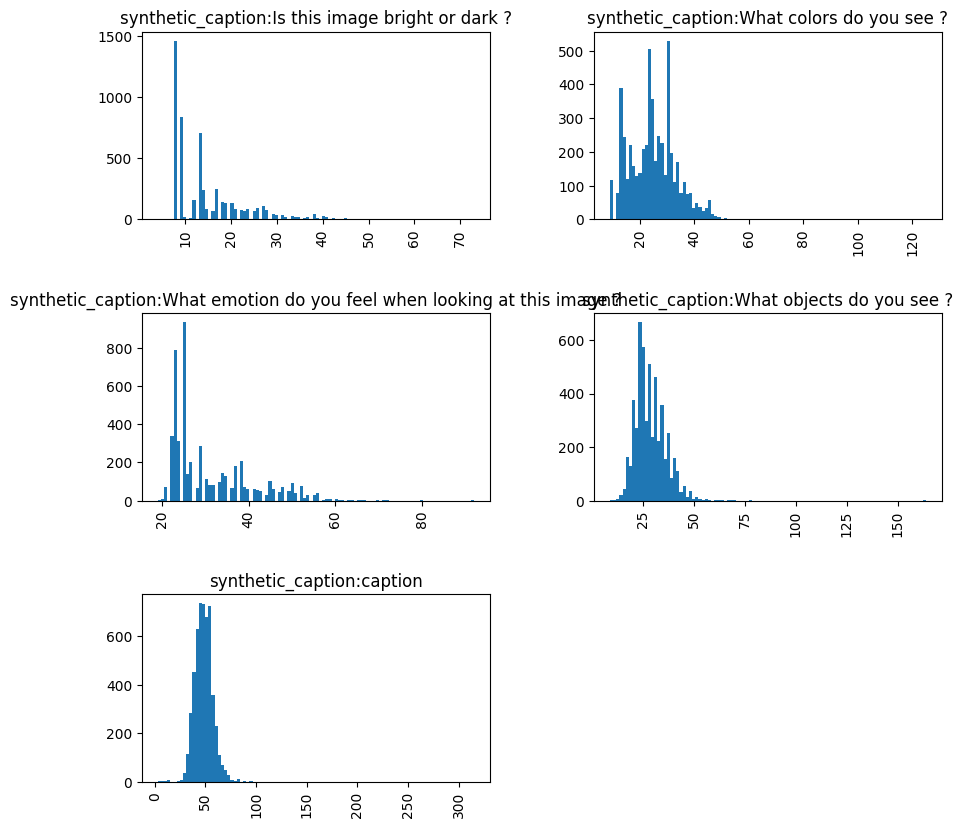

,row_type,<= TOKEN_LIMIT tokens,> TOKEN_LIMIT tokens,% <= TOKEN_LIMIT tokens,% > TOKEN_LIMIT tokens,Average overflow
0,synthetic_caption:caption,5271,30,99.43,0.57,25.2
1,synthetic_caption:What objects do you see ?,5299,2,99.96,0.04,46.0
2,synthetic_caption:What colors do you see ?,5299,2,99.96,0.04,31.0
4,synthetic_caption:What emotion do you feel whe...,5299,2,99.96,0.04,11.0
3,synthetic_caption:Is this image bright or dark ?,5301,0,100.00,0.00,NaN


In [111]:
def analyze_captions(training_dataset):
    # Recompute the number of tokens
    training_dataset["number_of_tokens"] = training_dataset["caption"].apply(lambda x: len(tokenizer.encode(x)))

    # Histogram of the number of tokens in function of the row type
    training_dataset["number_of_tokens"].hist(by=training_dataset["row_type"], bins=100, figsize=(10, 10))
    plt.show()

    # Table of the number of captions per row type having <= 77 tokens
    table_respecting_clip_limit = pd.DataFrame(columns=[
        "row_type", 
        "<= TOKEN_LIMIT tokens", 
        "> TOKEN_LIMIT tokens", 
        "% <= TOKEN_LIMIT tokens",
        "% > TOKEN_LIMIT tokens",
        "Average overflow"
    ])

    for row_type in training_dataset["row_type"].unique():
        
        rows = training_dataset[training_dataset["row_type"] == row_type]
        N = len(rows)

        rows_overflowing_clip_limit = rows[rows["number_of_tokens"] > TOKEN_LIMIT]
        rows_respecting_clip_limit = rows[rows["number_of_tokens"] <= TOKEN_LIMIT]

        N_respecting_clip_limit = len(rows_respecting_clip_limit)
        N_not_respecting_clip_limit = len(rows_overflowing_clip_limit)
        percentage_respecting_clip_limit = round((N_respecting_clip_limit / N) * 100, 2)
        percentage_not_respecting_clip_limit = round((N_not_respecting_clip_limit / N) * 100, 2)

        average_overflow = round(rows_overflowing_clip_limit["number_of_tokens"].mean() - TOKEN_LIMIT, 2)
        
        table_respecting_clip_limit.loc[len(table_respecting_clip_limit)] = [
            row_type,
            N_respecting_clip_limit,
            N_not_respecting_clip_limit,
            percentage_respecting_clip_limit,
            percentage_not_respecting_clip_limit,
            average_overflow
        ]

    # Order the table by the percentage of captions having > TOKEN_LIMIT tokens
    table_respecting_clip_limit = table_respecting_clip_limit.sort_values(by="% > TOKEN_LIMIT tokens", ascending=False)

    return table_respecting_clip_limit

analyze_captions(training_dataset)

#### The answers to the questions (except the questions regarding the brightness of the image) are clearly too long ! Lets analyze them !
I chose to just select the first sentence ! This solved this issue !
Below is my previous technic !

In [112]:
if False:
    from collections import Counter

    def get_redundant_words(captions, percentage_most_common):
        # Flatten all words into a single list
        all_words = " ".join(captions).lower().split()
        
        # Count word occurrences
        word_counts = Counter(all_words)
        
        # Get the most common words (percentage-based)
        num_words_to_remove = int(len(word_counts) * percentage_most_common)
        most_common_words = {word for word, _ in word_counts.most_common(num_words_to_remove)}
        
        return most_common_words

    # Test
    words = get_redundant_words(training_dataset["caption"], 0.005)
    print(words)

    # Sadly there are words that I would consider as interesting that are removed !
    # I will have to find a way to keep them while removing the most common words

    common_unnecessary_words_fr = {
        "un", "une", "le", "la", "les", "de", "du", "des", "à", "en", "dans", "sur", "sous",
        "avec", "sans", "pour", "par", "et", "ou", "mais", "donc", "or", "ni", "car",
        "est", "sont", "était", "étaient", "être", "été", "ayant", "avoir", "a", "as", "ai", "avons", 
        "avez", "ont", "avait", "avaient", "au", "aux", "ce", "cet", "cette", "ces", 
        "celui", "celle", "ceux", "celles", "lui", "elle", "eux", "elles", "il", "ils", "on", "nous",
        "vous", "mon", "ton", "son", "ma", "ta", "sa", "mes", "tes", "ses", "notre", "votre", "leur",
        "leurs", "quel", "quelle", "quels", "quelles", "quoi", "dont", "où", "comment", "quand",
        "avant", "après", "pendant", "depuis", "trop", "très", "peu", "beaucoup", "plus", "moins",
        "aussi", "ainsi", "alors", "comme", "si", "car", "que", "qui", "qu'", "quoi", "lorsque",
        "tant", "tel", "tels", "telle", "telles", "certains", "certaines", "chaque", "autre", "autres",
        "tous", "tout", "toute", "toutes", "encore", "déjà", "seulement", "même", "mêmes",
        "aucun", "aucune", "nul", "nulle", "rien", "personne", 
        
        "image", "L'image", "présente", "représente", "montre", "représente", "illustre", "illustre",
        "l'image", "y", "je", "tu", "il", "elle", "on", "nous", "vous", "ils", "elles", "ce", "cette", "ces",
        "vois"
    }
    symbols_to_remove = {
        ",", ".", "!", "?", "...", "''", "'''"
    }


    def remove_redundant_words(captions, words_to_remove):
        simplified_captions = []
        for caption in captions:
            simplified_caption = " ".join([word for word in caption.split() if word.lower() not in words_to_remove])
            simplified_caption = "".join([char for char in simplified_caption if char not in symbols_to_remove])
            simplified_captions.append(simplified_caption)
        
        return simplified_captions
    training_dataset["caption"] = remove_redundant_words(training_dataset["caption"], common_unnecessary_words_fr)
    analyze_captions(training_dataset)

    unique_row_types = training_dataset["row_type"].unique()
    head_size = 3
    for row_type in unique_row_types:
        print(row_type)
        for caption in training_dataset[training_dataset["row_type"] == row_type]["caption"].head(head_size):
            print(caption + "\n")
        print("\n")


In [113]:
print(f"Using only moondream captions, we have {len(training_dataset)} captions")

Using only moondream captions, we have 26505 captions


# 2) Insert the captions generated using the subject matter

In [114]:
def isFull(subjectmatter_caption):
    structured = subjectmatter_caption["structured"]
    unstructured = subjectmatter_caption["unstructured"]
    for key in structured.keys():
        #Check if the flat is not empty
        if len(structured[key]["flattened"]) == 0 or structured[key]["flattened"] is np.nan:
            return False
    for key in unstructured.keys():
        if pd.isna(unstructured[key]):
            return False
    return True

index = 0
while not isFull(subjectmatter_json[index]):
    index += 1

example_subjectmatter = subjectmatter_json[index]
example_subjectmatter

{'recordID': 119,
 'structured': {'subjectMatterSubjectTerms': {'tree': {'name': 'root',
    'children': [{'name': 'figure',
      'children': [{'name': 'homme',
        'children': [{'name': 'nu', 'children': []}]},
       {'name': 'mort', 'children': []},
       {'name': 'arme', 'children': [{'name': 'couteau', 'children': []}]},
       {'name': 'sang', 'children': []},
       {'name': 'lettre', 'children': []},
       {'name': "instrument d'écriture",
        'children': [{'name': 'plume', 'children': []}]},
       {'name': 'encrier', 'children': []}]},
     {'name': 'scène', 'children': [{'name': 'bain', 'children': []}]}]},
   'flattened': ['figure',
    'homme',
    'nu',
    'mort',
    'arme',
    'couteau',
    'sang',
    'lettre',
    "instrument d'écriture",
    'plume',
    'encrier',
    'scène',
    'bain']},
  'subjectMatterIconographicTerms': {'tree': {'name': 'root',
    'children': [{'name': 'portrait',
      'children': [{'name': 'Jean Paul Marat', 'children': []}]}

In [115]:
def get_caption_from__subjectMatterSubjectTerms(subjectMatterSubjectTerms):
    if len(subjectMatterSubjectTerms) == 0:
        return None
    else:
        return " ".join(subjectMatterSubjectTerms)

get_caption_from__subjectMatterSubjectTerms(example_subjectmatter["structured"]["subjectMatterSubjectTerms"]["flattened"])

"figure homme nu mort arme couteau sang lettre instrument d'écriture plume encrier scène bain"

In [116]:
def get_caption_from__subjectMatterIconographicTerms(subjectMatterIconographicTerms):
    if len(subjectMatterIconographicTerms) == 0:
        return None
    else:
        return " ".join(subjectMatterIconographicTerms)

get_caption_from__subjectMatterIconographicTerms(example_subjectmatter["structured"]["subjectMatterIconographicTerms"]["flattened"])

'portrait Jean Paul Marat meurtre révolution française'

In [117]:
def get_caption_from__subjectMatterConceptualTerms(subjectMatterConceptualTerms):
    if len(subjectMatterConceptualTerms) == 0:
        return None
    else:
        return " ".join(subjectMatterConceptualTerms)

get_caption_from__subjectMatterConceptualTerms(example_subjectmatter["structured"]["subjectMatterConceptualTerms"]["flattened"])


'martyre Marie-Anne Charlotte Corday Louis XVI'

In [118]:
def get_caption_from__subjectMatterIconographicInterpretation(subjectMatterIconographicInterpretation):
    if pd.isna(subjectMatterIconographicInterpretation):
        return None
    else:
        return subjectMatterIconographicInterpretation

get_caption_from__subjectMatterIconographicInterpretation(example_subjectmatter["unstructured"]["subjectMatterIconographicInterpretation"])

'Le 13 juillet 1793 Marie-Anne Charlotte Corday, partisane des Girondins, se fit introduire auprès de Marat, sous prétexte de lui communiquer des renseignements sur ceux-ci et le poignarda. Marat, qui souffrait d\'une maladie de la peau que seuls des bains soulageaient, travaillait souvent dans sa baignoire. Il publiait depuis 1789 le journal "L\'ami du peuple" : il tient encore son "arme", la plume, en main, représentée ici tout près de l\'arme encore ensanglantée du crime. On demanda à David d\'organiser la pompe des funérailles et de peindre un tableau commémoratif. De la mythologie classique qui jusqu\'alors constituait sa galerie de modèles, David passe ici à un héros de l\'histoire contemporaine. Il idéalise son héros en s\'en tenant à un strict réalisme. Le peintre est à ce moment l\'artiste français le plus en vue mais aussi un ami personnel de la victime ; tous deux ont voté, à la Convention, la mort de Louis XVI. (d\'après Frederik Leen, in \'Musée d\'Art Moderne. Oeuvres cho

In [119]:
def get_caption_from__subjectMatterGeneralSubjectDescription(subjectMatterGeneralSubjectDescription):
    if pd.isna(subjectMatterGeneralSubjectDescription):
        return None
    else:
        return subjectMatterGeneralSubjectDescription

get_caption_from__subjectMatterGeneralSubjectDescription(example_subjectmatter["unstructured"]["subjectMatterGeneralSubjectDescription"])

'Un homme avec une blessure à la poitrine gît, mort, dans une baignoire ; il tient une plume et une lettre ; sur une table sont posés une autre plume et un encrier ; sur le sol, un couteau ensanglanté.'

In [120]:
def get_caption_from__subjectMatterSpecificSubjectIdentification(subjectMatterSpecificSubjectIdentification):
    if pd.isna(subjectMatterSpecificSubjectIdentification):
        return None
    else:
        return subjectMatterSpecificSubjectIdentification

get_caption_from__subjectMatterSpecificSubjectIdentification(example_subjectmatter["unstructured"]["subjectMatterSpecificSubjectIdentification"])

'Marat assassiné'

In [121]:
subject_matter_captions = pd.DataFrame(columns=["record_id", "row_type", "caption", "number_of_tokens"])

for subjectmatter in tqdm(subjectmatter_json):
    record_id = subjectmatter["recordID"]
    
    # subjectMatterSubjectTerms
    subjectMatterSubjectTerms = get_caption_from__subjectMatterSubjectTerms(subjectmatter["structured"]["subjectMatterSubjectTerms"]["flattened"])
    if subjectMatterSubjectTerms is not None:
        row_type = "subjectMatterSubjectTerms"
        caption = subjectMatterSubjectTerms
        number_of_tokens = len(tokenizer.encode(caption))
        subject_matter_captions.loc[len(subject_matter_captions)] = [record_id, row_type, caption, number_of_tokens]

    # subjectMatterIconographicTerms
    subjectMatterIconographicTerms = get_caption_from__subjectMatterIconographicTerms(subjectmatter["structured"]["subjectMatterIconographicTerms"]["flattened"])
    if subjectMatterIconographicTerms is not None:
        row_type = "subjectMatterIconographicTerms"
        caption = subjectMatterIconographicTerms
        number_of_tokens = len(tokenizer.encode(caption))
        subject_matter_captions.loc[len(subject_matter_captions)] = [record_id, row_type, caption, number_of_tokens]

    # subjectMatterConceptualTerms
    subjectMatterConceptualTerms = get_caption_from__subjectMatterConceptualTerms(subjectmatter["structured"]["subjectMatterConceptualTerms"]["flattened"])
    if subjectMatterConceptualTerms is not None:
        row_type = "subjectMatterConceptualTerms"
        caption = subjectMatterConceptualTerms
        number_of_tokens = len(tokenizer.encode(caption))
        subject_matter_captions.loc[len(subject_matter_captions)] = [record_id, row_type, caption, number_of_tokens]

    # subjectMatterIconographicInterpretation
    subjectMatterIconographicInterpretation = get_caption_from__subjectMatterIconographicInterpretation(subjectmatter["unstructured"]["subjectMatterIconographicInterpretation"])
    if subjectMatterIconographicInterpretation is not None:
        row_type = "subjectMatterIconographicInterpretation"
        caption = subjectMatterIconographicInterpretation
        number_of_tokens = len(tokenizer.encode(caption))
        subject_matter_captions.loc[len(subject_matter_captions)] = [record_id, row_type, caption, number_of_tokens]

    # subjectMatterGeneralSubjectDescription
    subjectMatterGeneralSubjectDescription = get_caption_from__subjectMatterGeneralSubjectDescription(subjectmatter["unstructured"]["subjectMatterGeneralSubjectDescription"])
    if subjectMatterGeneralSubjectDescription is not None:
        row_type = "subjectMatterGeneralSubjectDescription"
        caption = subjectMatterGeneralSubjectDescription
        number_of_tokens = len(tokenizer.encode(caption))
        subject_matter_captions.loc[len(subject_matter_captions)] = [record_id, row_type, caption, number_of_tokens]

    # subjectMatterSpecificSubjectIdentification
    subjectMatterSpecificSubjectIdentification = get_caption_from__subjectMatterSpecificSubjectIdentification(subjectmatter["unstructured"]["subjectMatterSpecificSubjectIdentification"])
    if subjectMatterSpecificSubjectIdentification is not None:
        row_type = "subjectMatterSpecificSubjectIdentification"
        caption = subjectMatterSpecificSubjectIdentification
        number_of_tokens = len(tokenizer.encode(caption))
        subject_matter_captions.loc[len(subject_matter_captions)] = [record_id, row_type, caption, number_of_tokens]


subject_matter_captions

100%|██████████| 5301/5301 [00:05<00:00, 949.66it/s] 


,record_id,row_type,caption,number_of_tokens
0,64,subjectMatterSubjectTerms,scène homme femme enfant vêtement habit robe c...,52
1,64,subjectMatterIconographicTerms,scène biblique [SO] Nouveau Testament Evangile...,34
2,77,subjectMatterSubjectTerms,figure femme arbre table chaise,9
3,78,subjectMatterSubjectTerms,figure enfant de face robe noeud intérieur chaise,17
4,78,subjectMatterIconographicTerms,portrait fillette Louise van der Hecht,10
...,...,...,...,...
7856,11645,subjectMatterSubjectTerms,figure femme en buste vêtement robe coiffe,15
7857,11646,subjectMatterSubjectTerms,figure homme en buste habit,8
7858,11805,subjectMatterSubjectTerms,groupe de figures ouvrier bâtiment voûte machine,17
7859,11805,subjectMatterIconographicTerms,scène travail,7


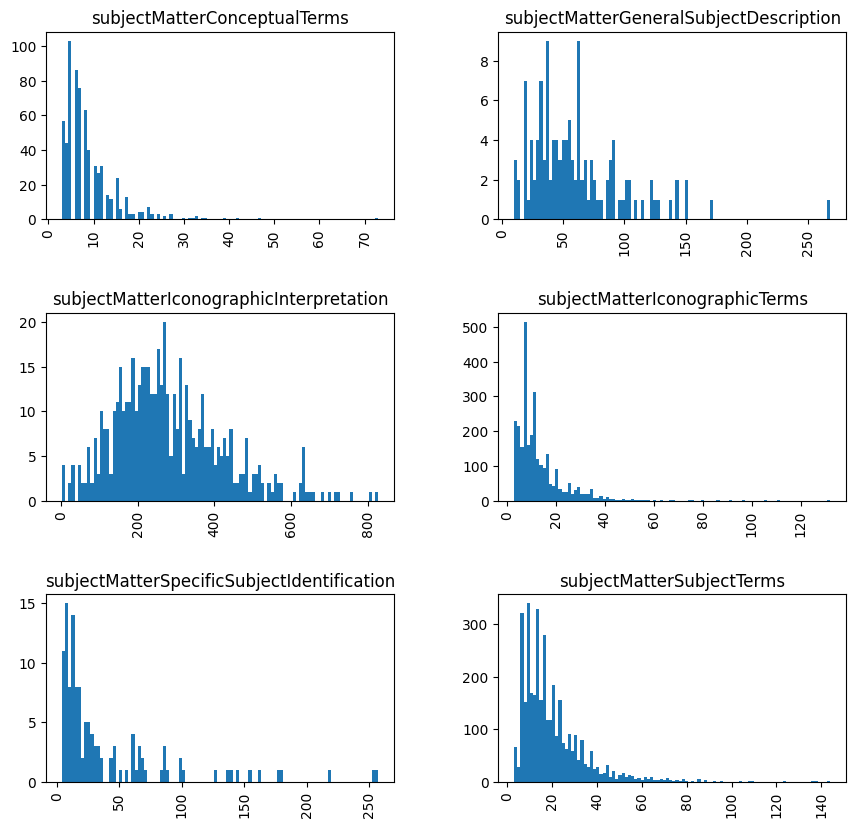

,row_type,<= TOKEN_LIMIT tokens,> TOKEN_LIMIT tokens,% <= TOKEN_LIMIT tokens,% > TOKEN_LIMIT tokens,Average overflow
2,subjectMatterIconographicInterpretation,21,495,4.07,95.93,214.84
4,subjectMatterGeneralSubjectDescription,92,31,74.80,25.20,38.77
5,subjectMatterSpecificSubjectIdentification,106,19,84.80,15.20,66.05
0,subjectMatterSubjectTerms,3581,29,99.20,0.80,20.41
1,subjectMatterIconographicTerms,2809,8,99.72,0.28,22.38
3,subjectMatterConceptualTerms,670,0,100.00,0.00,NaN


In [122]:
analyze_captions(subject_matter_captions)

# 3) Compile both training datasets

In [123]:
full_training_dataset = pd.concat([training_dataset, subject_matter_captions], ignore_index=True)
full_training_dataset

,record_id,row_type,caption,number_of_tokens
0,64,synthetic_caption:caption,Une scène religieuse présente une figure centr...,56
1,64,synthetic_caption:What objects do you see ?,"À l'image, il y a deux personnes sur une croix...",34
2,64,synthetic_caption:What colors do you see ?,L'image présente une peinture avec un schéma d...,28
3,64,synthetic_caption:Is this image bright or dark ?,L'image est sombre,8
4,64,synthetic_caption:What emotion do you feel whe...,"En regardant cette image, je ressens un sentim...",23
...,...,...,...,...
34361,11645,subjectMatterSubjectTerms,figure femme en buste vêtement robe coiffe,15
34362,11646,subjectMatterSubjectTerms,figure homme en buste habit,8
34363,11805,subjectMatterSubjectTerms,groupe de figures ouvrier bâtiment voûte machine,17
34364,11805,subjectMatterIconographicTerms,scène travail,7


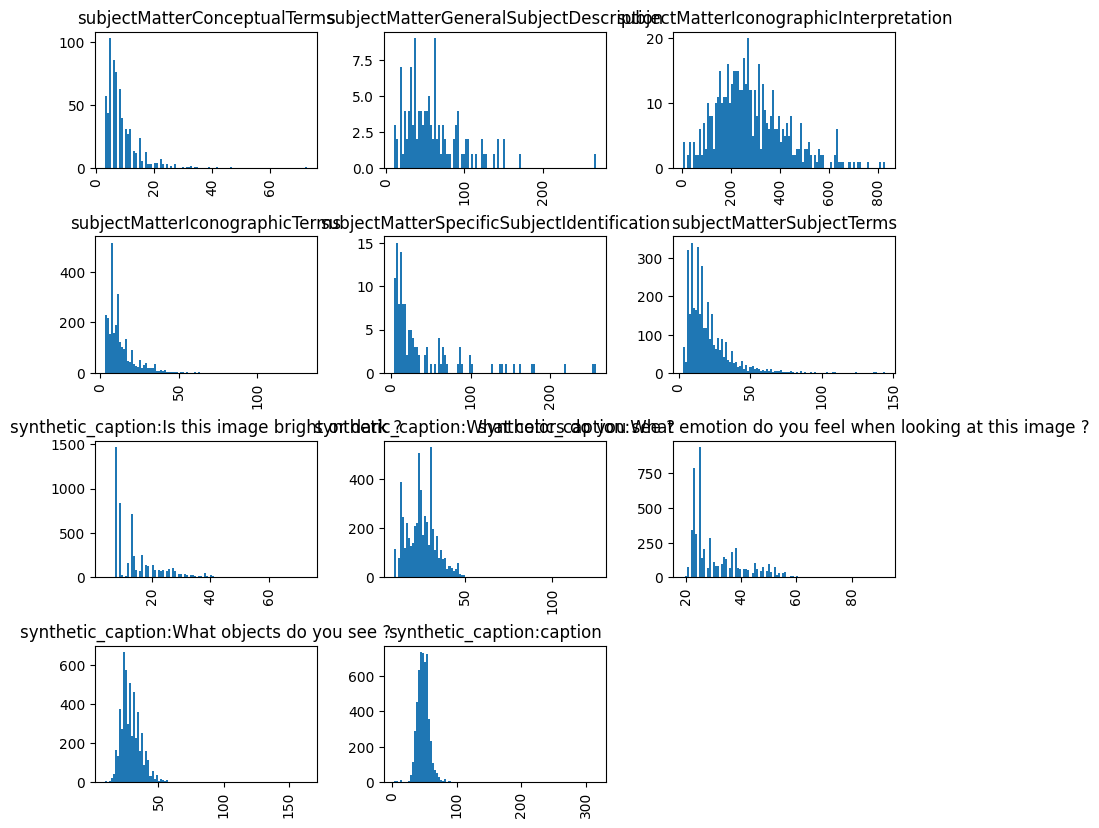

,row_type,<= TOKEN_LIMIT tokens,> TOKEN_LIMIT tokens,% <= TOKEN_LIMIT tokens,% > TOKEN_LIMIT tokens,Average overflow
7,subjectMatterIconographicInterpretation,21,495,4.07,95.93,214.84
9,subjectMatterGeneralSubjectDescription,92,31,74.80,25.20,38.77
10,subjectMatterSpecificSubjectIdentification,106,19,84.80,15.20,66.05
5,subjectMatterSubjectTerms,3581,29,99.20,0.80,20.41
0,synthetic_caption:caption,5271,30,99.43,0.57,25.20
6,subjectMatterIconographicTerms,2809,8,99.72,0.28,22.38
1,synthetic_caption:What objects do you see ?,5299,2,99.96,0.04,46.00
2,synthetic_caption:What colors do you see ?,5299,2,99.96,0.04,31.00
4,synthetic_caption:What emotion do you feel whe...,5299,2,99.96,0.04,11.00
3,synthetic_caption:Is this image bright or dark ?,5301,0,100.00,0.00,NaN


In [124]:
analyze_captions(full_training_dataset)

# 4) Clean the full dataset so that it only contains short enough captions

In [125]:
# We allow a 10 tokens overflow, the truncation will take care of it
clean_full_training_dataset = full_training_dataset[full_training_dataset["number_of_tokens"] <= TOKEN_LIMIT + 10]
clean_full_training_dataset

,record_id,row_type,caption,number_of_tokens
0,64,synthetic_caption:caption,Une scène religieuse présente une figure centr...,56
1,64,synthetic_caption:What objects do you see ?,"À l'image, il y a deux personnes sur une croix...",34
2,64,synthetic_caption:What colors do you see ?,L'image présente une peinture avec un schéma d...,28
3,64,synthetic_caption:Is this image bright or dark ?,L'image est sombre,8
4,64,synthetic_caption:What emotion do you feel whe...,"En regardant cette image, je ressens un sentim...",23
...,...,...,...,...
34361,11645,subjectMatterSubjectTerms,figure femme en buste vêtement robe coiffe,15
34362,11646,subjectMatterSubjectTerms,figure homme en buste habit,8
34363,11805,subjectMatterSubjectTerms,groupe de figures ouvrier bâtiment voûte machine,17
34364,11805,subjectMatterIconographicTerms,scène travail,7


C:\Users\victo\AppData\Local\Temp\ipykernel_1100\3513188944.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_dataset["number_of_tokens"] = training_dataset["caption"].apply(lambda x: len(tokenizer.encode(x)))


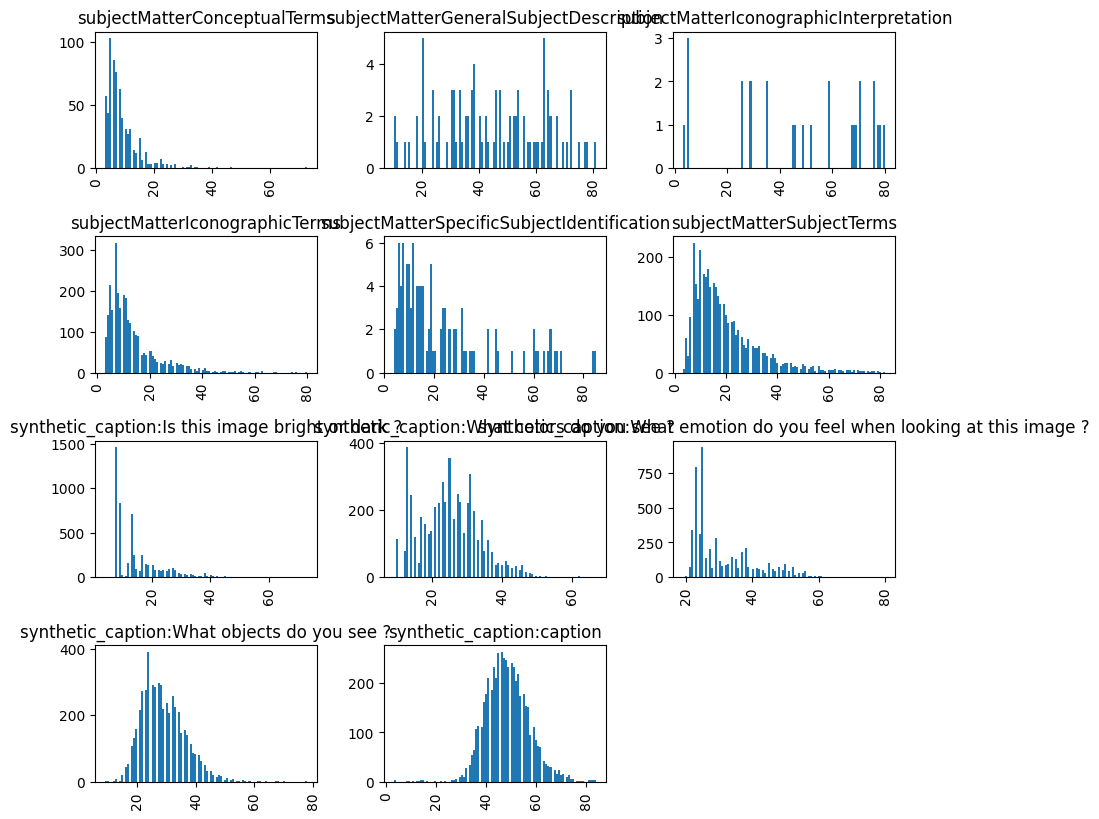

,row_type,<= TOKEN_LIMIT tokens,> TOKEN_LIMIT tokens,% <= TOKEN_LIMIT tokens,% > TOKEN_LIMIT tokens,Average overflow
10,subjectMatterIconographicInterpretation,21,5,80.77,19.23,2.40
8,subjectMatterGeneralSubjectDescription,92,3,96.84,3.16,3.67
9,subjectMatterSpecificSubjectIdentification,106,2,98.15,1.85,9.50
0,synthetic_caption:caption,5271,20,99.62,0.38,6.10
5,subjectMatterSubjectTerms,3581,10,99.72,0.28,3.40
6,subjectMatterIconographicTerms,2809,2,99.93,0.07,3.00
1,synthetic_caption:What objects do you see ?,5299,1,99.98,0.02,3.00
4,synthetic_caption:What emotion do you feel whe...,5299,1,99.98,0.02,5.00
2,synthetic_caption:What colors do you see ?,5299,0,100.00,0.00,NaN
3,synthetic_caption:Is this image bright or dark ?,5301,0,100.00,0.00,NaN


In [126]:
analyze_captions(clean_full_training_dataset)

In [127]:
clean_full_training_dataset.to_csv(PARENT + os.getenv("FILE_FULL_TRAINING_DATASET"), index=False)
print("Exported !")

Exported !
